In [1]:
import json
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,10)
import gc
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")
from functools import partial
import statsmodels.api as sm

import scipy as sp
from math import sqrt
from IPython.display import display 
from time import time

import pingouin as pg

In [2]:


with open("configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources']]

sources


['prm-datasets/processed/worldbank\\data.csv',
 'prm-datasets/processed/emdat\\data.csv',
 'prm-datasets/processed/displacement\\data.csv',
 'prm-datasets/processed/UNHCR\\data.csv',
 'prm-datasets/processed/ACLED\\data.csv',
 'prm-datasets/processed/FIW\\data.csv',
 'prm-datasets/processed/WHO\\data.csv',
 'prm-datasets/processed/SystemicPeace\\data.csv',
 'prm-datasets/processed/corruption\\data.csv']

In [3]:
# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))



# Now arrange data in long form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)


Sources            : 9
Shape              : 434933 (rows) 6 (columns)
Geographies        : 400
Indicators         : 81
Temporal coverage  : 1946 -> 2018
Null values        : 1410


In [4]:
data.describe()

Indicator Code,year,ACLED.COUNT,ACLED.FATALITIES,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,DRC.CORR.INDEX,EG.ELC.ACCS.ZS,EMDAT.CPX.AFFECTED,EMDAT.CPX.OCCURRENCE,EMDAT.CPX.TOTAL.AFFECTED,...,WHO.EXT.HTLTH.EXP,WHO.INF.DTH,WHO.MAT.DEATHS,WHO.MAT.MORT.RATIO,WHO.NEO.DTH,WHO.NUM.TB.CAS,WHO.OOP.HLTH.EXP,WHO.TB.CAS,WHO.TB.TMT.COV,WHO.UND.FIV.DTH
count,20279.000000,1115.000000,1115.000000,12282.000000,12249.000000,2688.000000,6958.000000,1.300000e+01,13.0,1.300000e+01,...,2495.000000,5238.000000,539.000000,543.000000,5238.000000,3.275000e+03,3024.000000,3.189000e+03,3156.000000,5238.000000
mean,1986.737956,271.226009,846.426009,81.003146,78.461572,19.264940,75.020047,1.514316e+06,1.0,1.514316e+06,...,9.984970,32.957808,2367.575139,262.046041,19.290187,5.598508e+04,34.208036,2.834934e+04,72.674905,46.406835
std,17.941115,1092.387856,4473.382027,49.353073,52.654163,22.694826,32.627418,2.248886e+06,0.0,2.248886e+06,...,15.157703,139.150550,9747.012679,373.077349,91.849246,2.519196e+05,19.981651,1.184176e+05,19.266099,192.929032
min,1946.000000,1.000000,0.000000,0.060000,4.320000,0.900000,0.000000,3.000000e+03,1.0,3.000000e+03,...,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,2.900000,0.000000
25%,1972.000000,7.000000,2.000000,52.720751,48.850000,2.900000,53.150070,5.000000e+04,1.0,5.000000e+04,...,0.200000,0.000000,12.000000,21.000000,0.000000,4.400000e+02,17.600000,3.910000e+02,61.000000,0.000000
50%,1987.000000,27.000000,16.000000,81.550000,79.250000,6.100000,93.940540,7.100000e+05,1.0,7.100000e+05,...,2.800000,3.000000,130.000000,79.000000,2.000000,4.500000e+03,31.900000,3.233000e+03,80.000000,4.000000
75%,2002.000000,145.500000,219.500000,100.647500,100.548991,33.000000,100.000000,2.000000e+06,1.0,2.000000e+06,...,13.050000,22.000000,1350.000000,397.000000,12.000000,2.000000e+04,48.700000,1.247700e+04,87.000000,29.000000
max,2018.000000,21550.000000,77035.000000,1094.430000,1224.920000,92.000000,100.000000,8.000000e+06,1.0,8.000000e+06,...,93.000000,2400.000000,152000.000000,2650.000000,1600.000000,3.190000e+06,96.700000,1.763876e+06,280.000000,3400.000000


In [5]:
df1 = df.loc[(df['Country Name'] == 'Afghanistan')]
# Now arrange data in long form
data = pd.pivot_table(df1, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)


indicators_raw = data.columns.values 
indicators_raw = np.delete(indicators_raw, [0,1])

In [6]:
indicators = []
for i in indicators_raw:
    if (i!="IDP")&("UNHCR" not in i):
        indicators.append(i)

In [7]:
indicators

['ACLED.COUNT',
 'ACLED.FATALITIES',
 'AG.PRD.FOOD.XD',
 'AG.PRD.LVSK.XD',
 'DRC.CORR.INDEX',
 'EG.ELC.ACCS.ZS',
 'EMDAT.NAT.AFFECTED',
 'EMDAT.NAT.HOMELESS',
 'EMDAT.NAT.INJURED',
 'EMDAT.NAT.OCCURRENCE',
 'EMDAT.NAT.TOTAL.AFFECTED',
 'EMDAT.NAT.TOTAL.DAMAGE',
 'EMDAT.NAT.TOTAL.DEATHS',
 'EMDAT.TEC.AFFECTED',
 'EMDAT.TEC.HOMELESS',
 'EMDAT.TEC.INJURED',
 'EMDAT.TEC.OCCURRENCE',
 'EMDAT.TEC.TOTAL.AFFECTED',
 'EMDAT.TEC.TOTAL.DEATHS',
 'EN.ATM.PM25.MC.M3',
 'EN.POP.DNST',
 'ER.H2O.INTR.PC',
 'FIW.CL',
 'FIW.PR',
 'FP.CPI.TOTL.ZG',
 'IQ.CPA.PROP.XQ',
 'IT.NET.USER.ZS',
 'NY.GDP.PCAP.PP.CD',
 'SE.ADT.LITR.ZS',
 'SL.UEM.TOTL.FE.ZS',
 'SL.UEM.TOTL.MA.ZS',
 'SL.UEM.TOTL.ZS',
 'SP.DYN.TFRT.IN',
 'SP.POP.2024.FE.5Y',
 'SP.POP.2024.MA.5Y',
 'SP.POP.2529.FE.5Y',
 'SP.POP.2529.MA.5Y',
 'SP.POP.DPND',
 'SP.POP.TOTL',
 'SP.POP.TOTL.FE.ZS',
 'SP.PV.CIV.VIOL',
 'SP.PV.CIV.WAR',
 'SP.PV.ETH.VIOL',
 'SP.PV.ETH.WAR',
 'SP.PV.INDP',
 'SP.PV.INT.VIOL',
 'SP.PV.INT.WAR',
 'SP.RUR.TOTL',
 'SP.SF.MAG.COLLAPS

In [8]:
def explain(data, indicator):
    sub_df = data.loc[~(data[indicator].isna())]
    year_from = np.nan_to_num(sub_df['year'].min())
    year_to = np.nan_to_num(sub_df['year'].max())
    #years = np.nan_to_num(sub_df['year'].count())
    count = np.nan_to_num(data[indicator].count())
    min = np.nan_to_num(data[indicator].min())
    max = np.nan_to_num(data[indicator].max())
    mean = np.nan_to_num(data[indicator].mean())
    std = np.nan_to_num(data[indicator].std())
    nan = np.nan_to_num(data[indicator].isna().sum())
    percent = nan/(count+nan)*100
    outliers = data.loc[~((np.abs(data[indicator]-data[indicator].mean()) > (2*data[indicator].std()))
                                 |(np.abs(data[indicator]-data[indicator].mean()) < (2*data[indicator].std())))][indicator].dropna().count()
    if outliers > 0:
        outliers = True
    else:
        outliers = False   
    
    #print("count=%d\nmin=%d\nmax=%d\nmean=%d\nstd=%d\nnan count=%d, percent=%d%%\nouliers=%r\nyears covered %d-%d" % (count, min, max, mean,std, nan,percent, outliers, year_from, year_to))
    return count, min, max, mean,std, nan,percent, outliers, year_from, year_to

In [9]:
result_df = pd.DataFrame(columns = ['Indicator Name', 'years', 'count', 'min', 'max', 'mean', 'std', 'nan, %','outliers'])

In [10]:
for i in indicators_raw:
    count, min, max, mean,std, nan,percent, outliers, year_from, year_to = explain(data, i)
    new_row = {'Indicator Name':i, 'years':str(year_from)+'-'+str(year_to), 'count':count, 'min':min, 'max':max, 'mean':mean, 'std':std, 'nan, %':percent,'outliers':outliers}
    result_df=result_df.append(new_row, ignore_index=True)

In [11]:
result_df.to_csv("Afghanistan.csv", index = None, header=True, columns=result_df.columns )

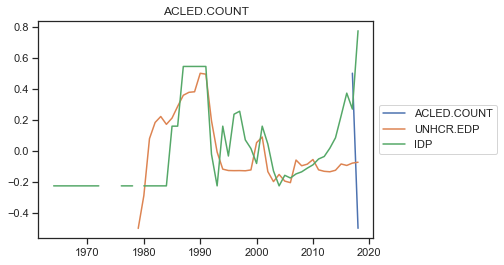

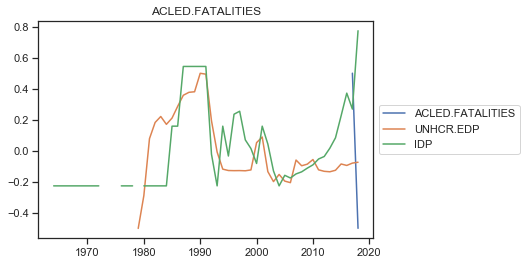

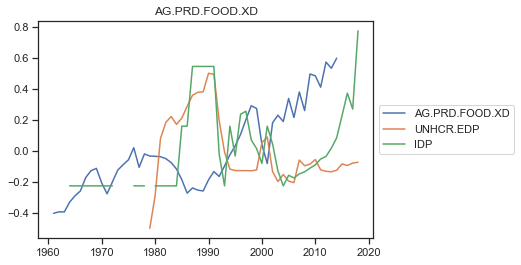

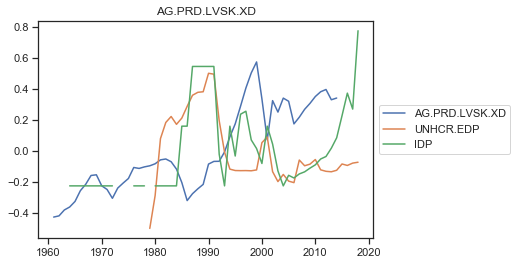

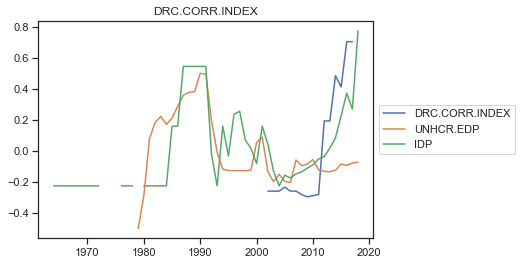

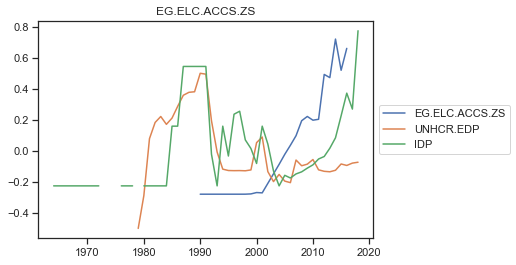

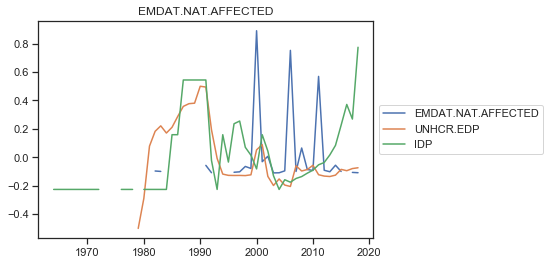

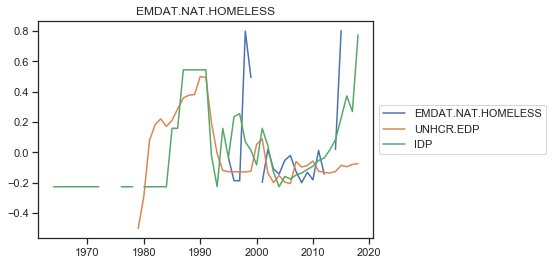

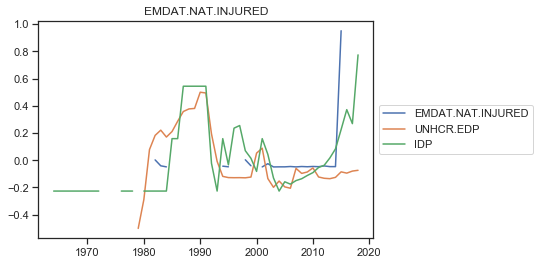

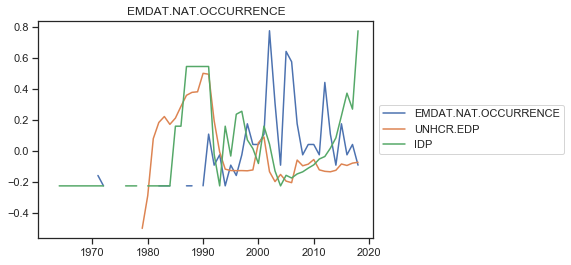

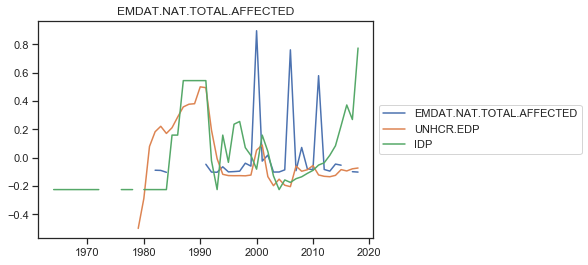

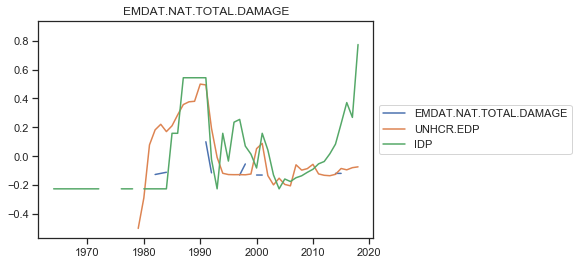

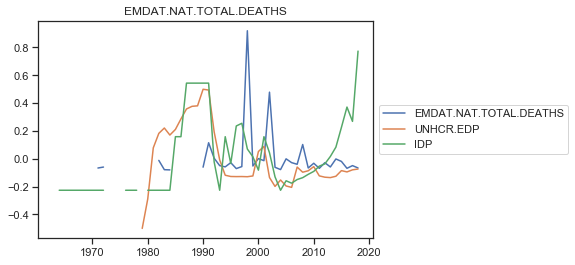

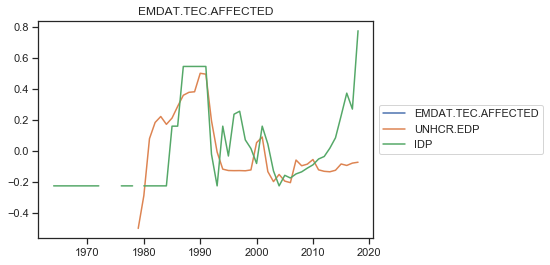

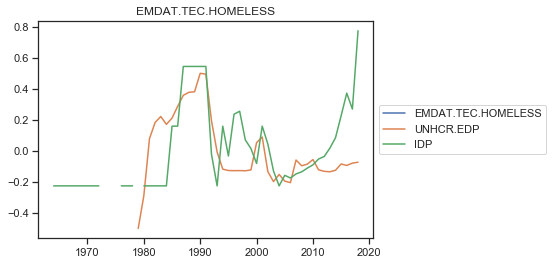

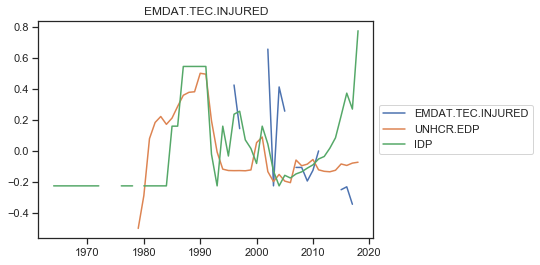

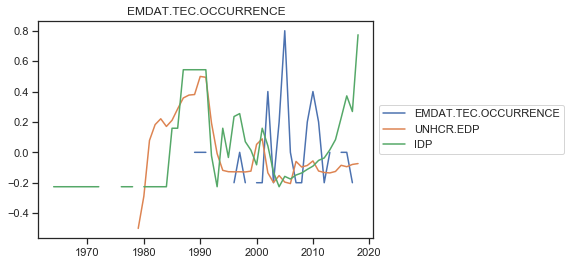

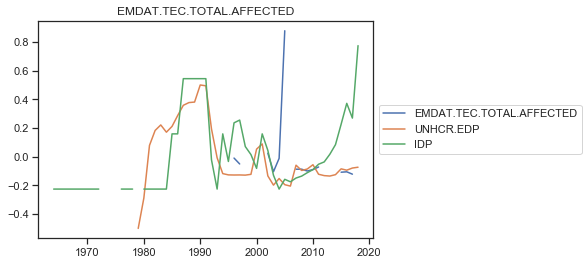

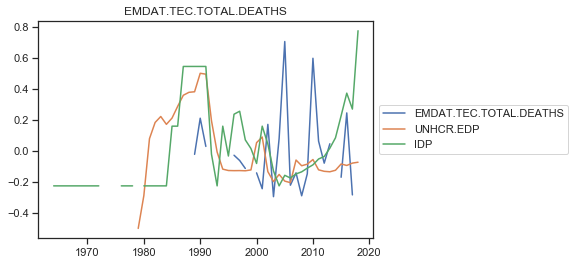

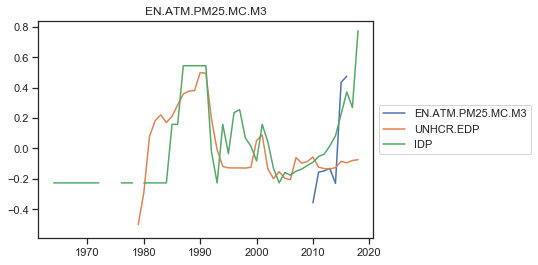

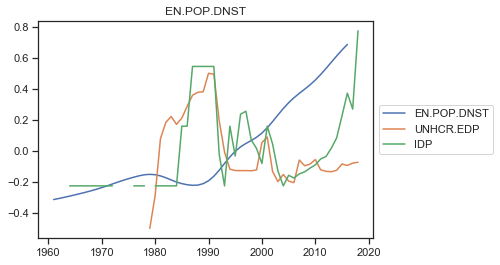

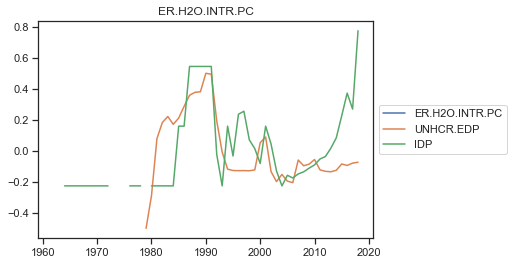

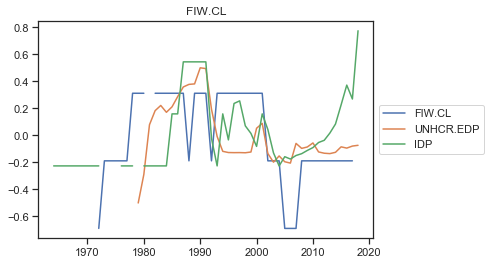

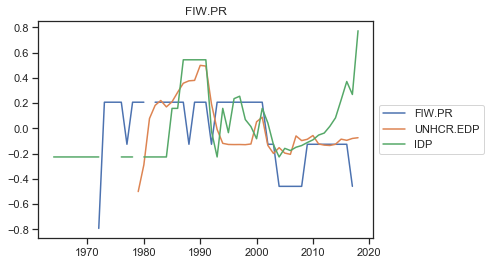

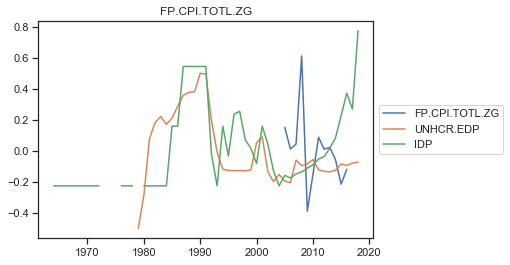

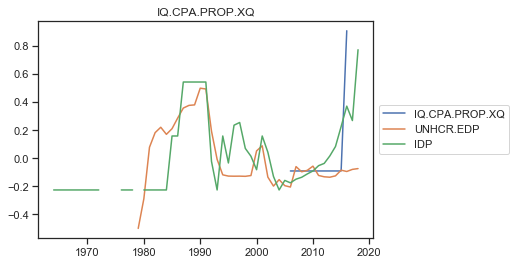

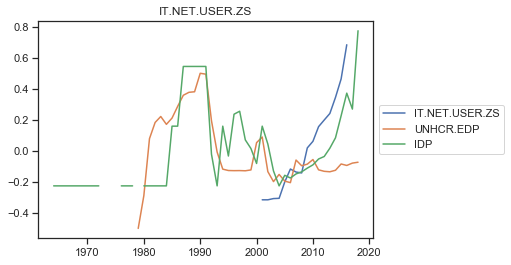

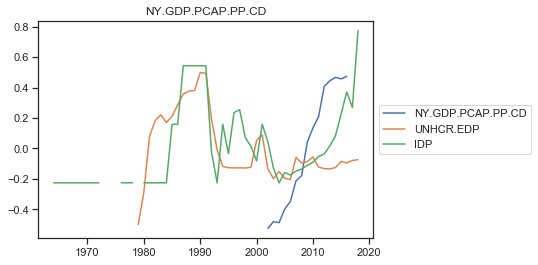

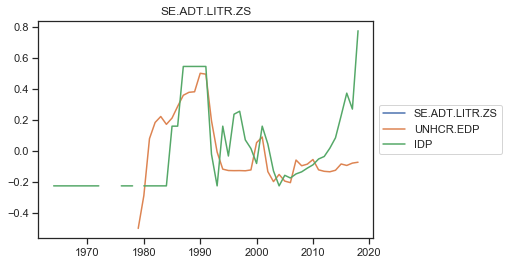

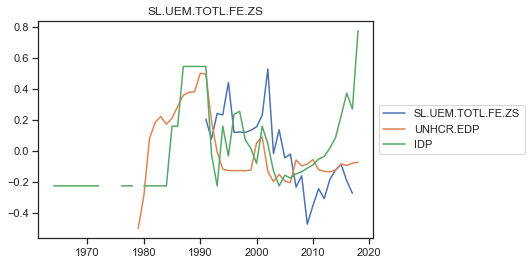

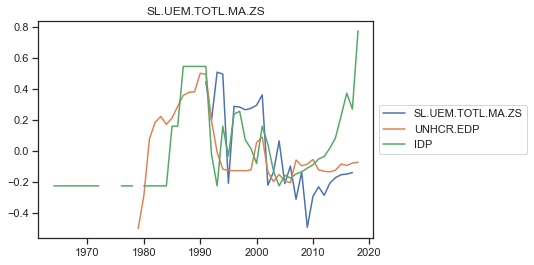

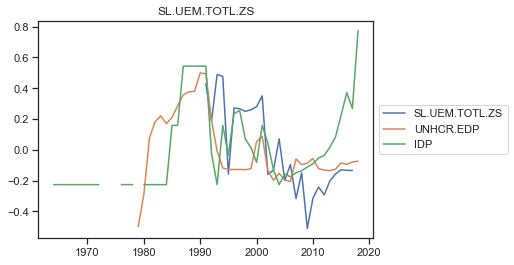

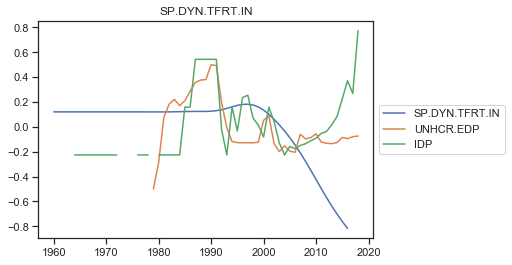

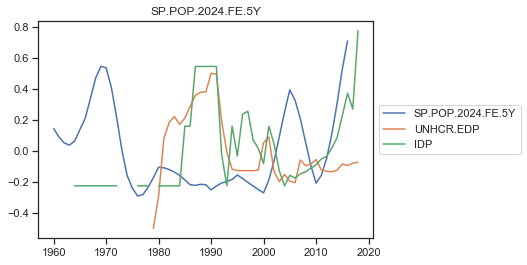

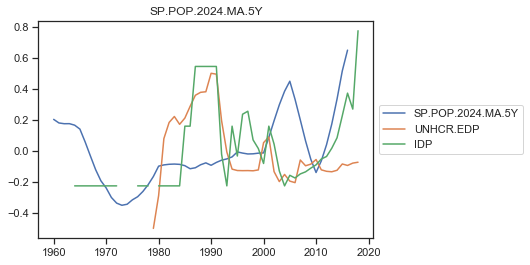

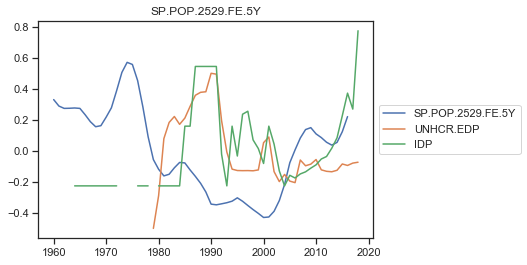

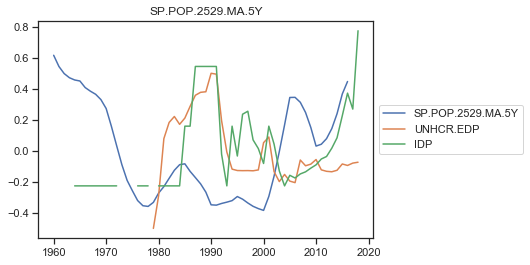

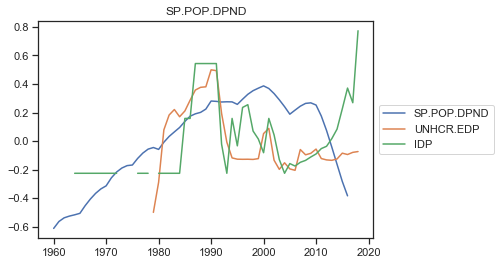

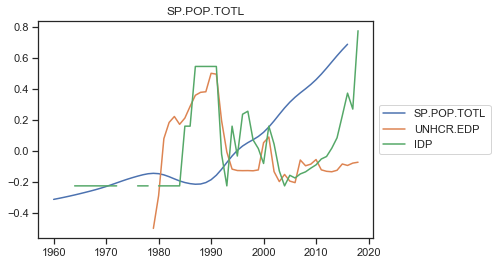

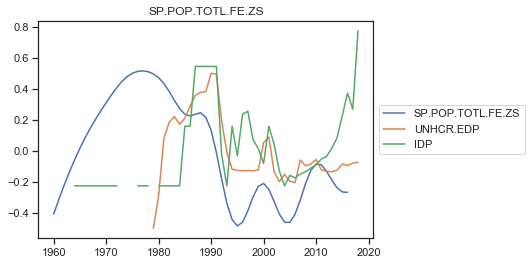

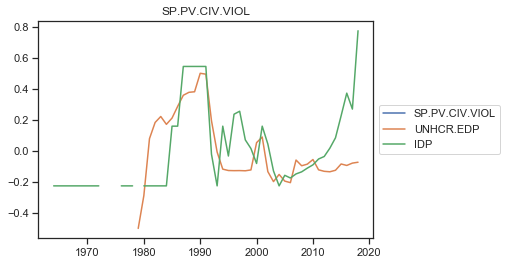

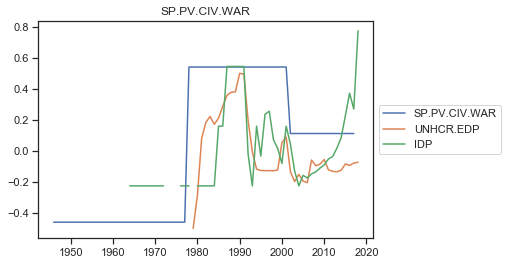

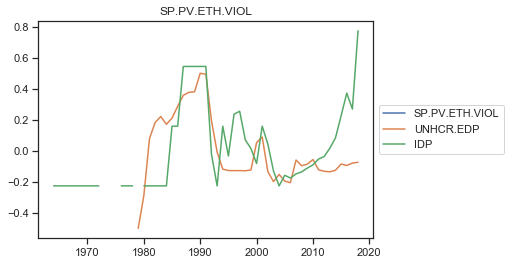

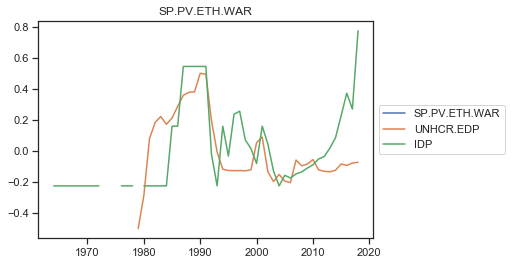

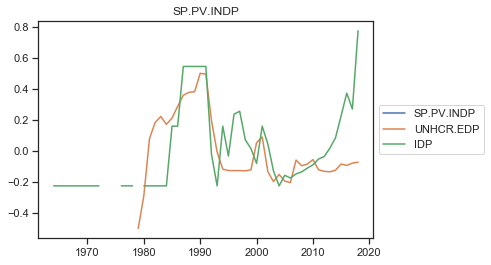

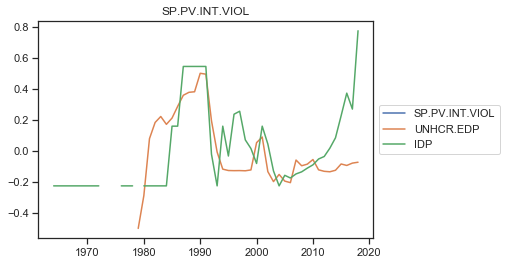

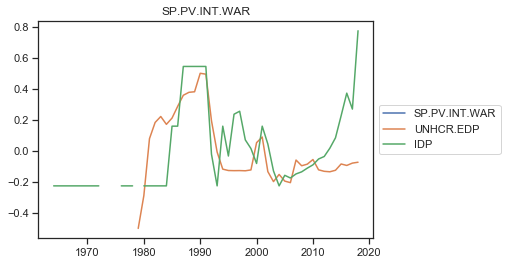

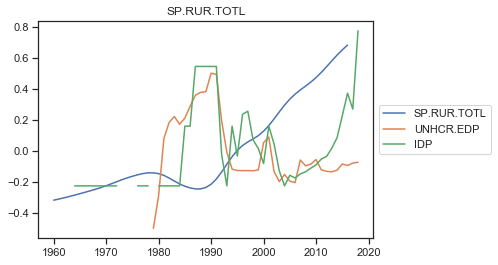

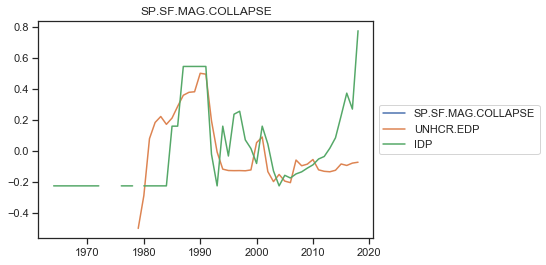

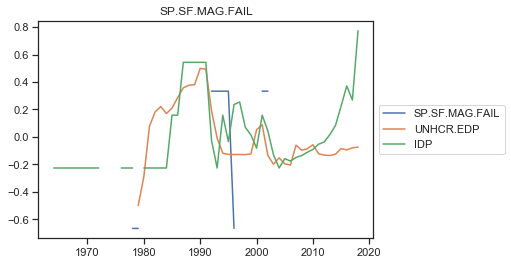

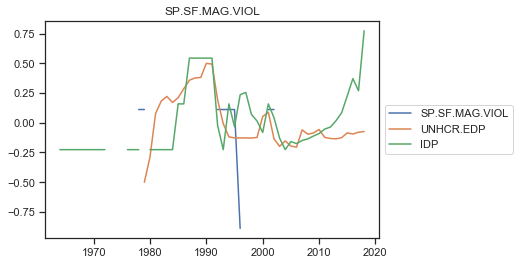

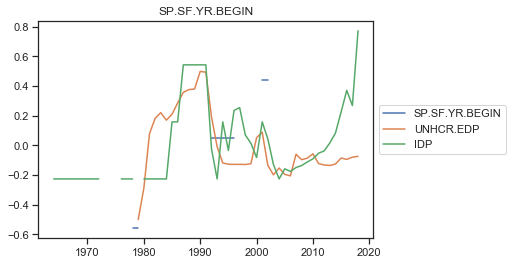

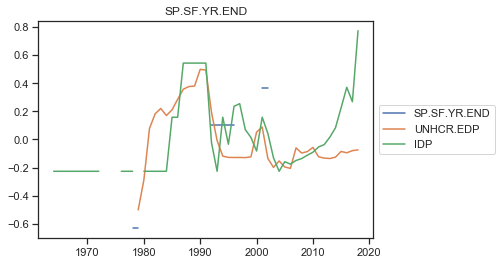

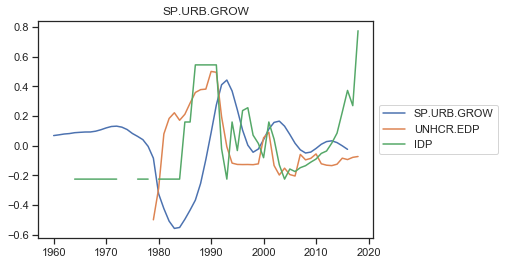

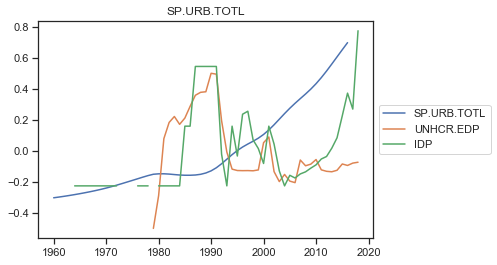

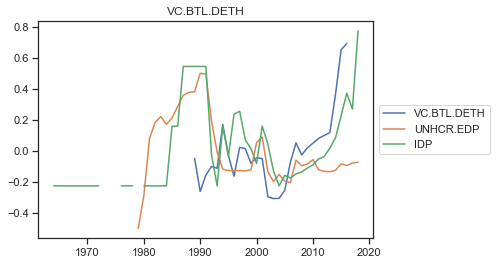

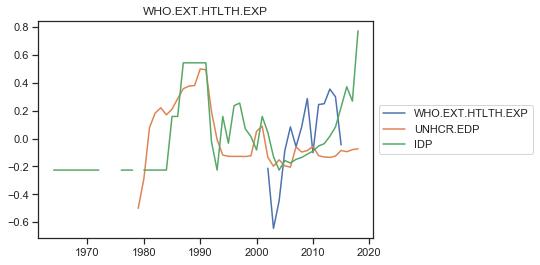

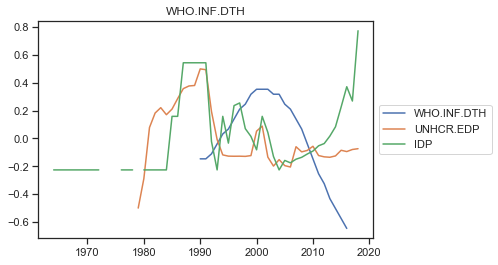

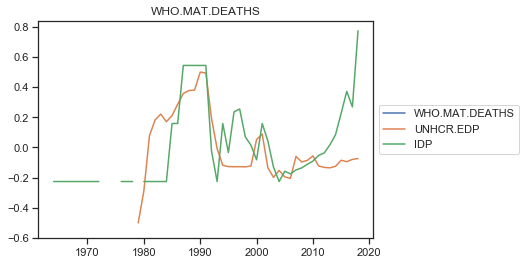

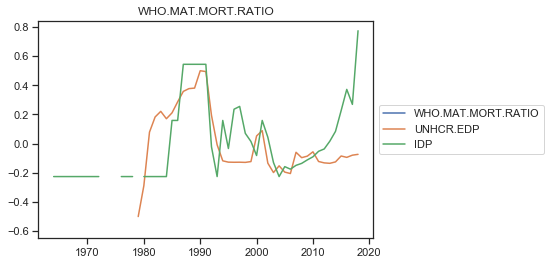

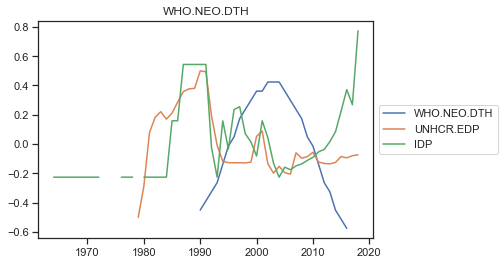

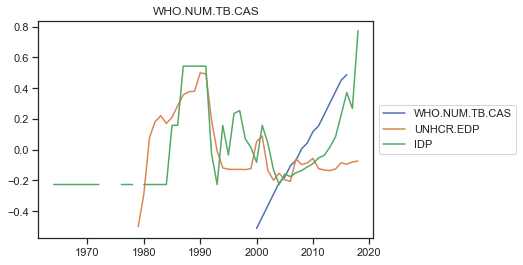

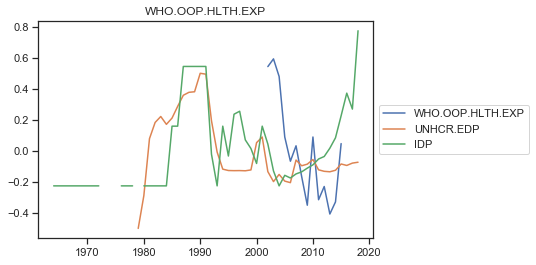

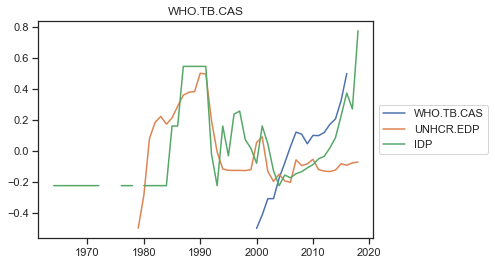

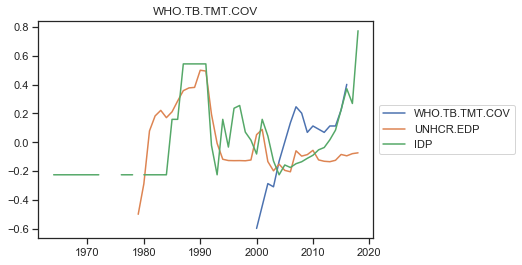

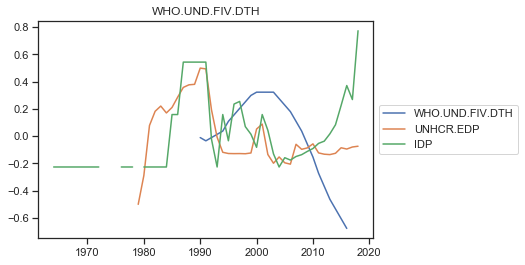

In [12]:
data['IDP'] = data['IDP'].apply(lambda x: (x - np.mean(data['IDP'])) / (np.max(data['IDP']) - np.min(data['IDP'])))
data['UNHCR.EDP'] = data['UNHCR.EDP'].apply(lambda x: (x - np.mean(data['UNHCR.EDP'])) / (np.max(data['UNHCR.EDP']) - np.min(data['UNHCR.EDP'])))

for i in indicators:
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    plt.plot(data.year,data[i].values)
    plt.plot(data.year,data['UNHCR.EDP'].values)
    plt.plot(data.year,data['IDP'].values)
    plt.title(i)
    plt.legend([i, 'UNHCR.EDP', 'IDP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [13]:
df1 = df.loc[(df['Country Name'] == 'Afghanistan')]
# Now arrange data in long form
data = pd.pivot_table(df1, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)




In [14]:
EDP_df = pd.DataFrame(columns = ['Indicator Name', 'n', 'r', 'CI95%', 'r2', 'adj_r2', 'p-val', 'BF10',  'power'])
IDP_df = pd.DataFrame(columns = ['Indicator Name', 'n', 'r', 'CI95%', 'r2', 'adj_r2', 'p-val', 'BF10',  'power'])

In [15]:

for i in indicators:
    count = np.nan_to_num(data[i].count())
    if count>10:
        try:
            res = pg.corr(x=data[i].values, y=data['UNHCR.EDP'].values).reset_index()
            new_row = {'Indicator Name':i,  'n':res.n.values[0], 'r':res.r.values[0], 'CI95%':res['CI95%'].values[0],
                       'r2':res.r2.values[0], 'adj_r2':res.adj_r2.values[0], 'p-val':res['p-val'].values[0],
                       'BF10':res.BF10.values[0],  'power':res.power.values[0]}
            EDP_df=EDP_df.append(new_row, ignore_index=True)
            res = pg.corr(x=data[i].values, y=data['IDP'].values).reset_index()
            new_row = {'Indicator Name':i,  'n':res.n.values[0], 'r':res.r.values[0], 'CI95%':res['CI95%'].values[0],
                       'r2':res.r2.values[0], 'adj_r2':res.adj_r2.values[0], 'p-val':res['p-val'].values[0],
                       'BF10':res.BF10.values[0],  'power':res.power.values[0]}
            IDP_df=IDP_df.append(new_row, ignore_index=True)
        except:
            continue

In [16]:
EDP_df = EDP_df.sort_values(by='r2', ascending=False)
EDP_df

,Indicator Name,n,r,CI95%,r2,adj_r2,p-val,BF10,power
17,ER.H2O.INTR.PC,8,0.917,"[0.6, 0.99]",0.841,0.778,0.001327,29.641,0.955
0,AG.PRD.FOOD.XD,36,-0.642,"[-0.8, -0.4]",0.412,0.377,0.000024,1082.654,0.993
1,AG.PRD.LVSK.XD,36,-0.638,"[-0.8, -0.39]",0.407,0.372,0.000028,944.944,0.992
36,SP.RUR.TOTL,38,-0.566,"[-0.75, -0.3]",0.320,0.281,0.000215,147.248,0.970
33,SP.POP.TOTL,38,-0.543,"[-0.73, -0.27]",0.294,0.254,0.000432,78.638,0.953
16,EN.POP.DNST,38,-0.543,"[-0.73, -0.27]",0.294,0.254,0.000432,78.638,0.953
38,SP.URB.TOTL,38,-0.489,"[-0.7, -0.2]",0.239,0.196,0.001820,21.798,0.893
23,NY.GDP.PCAP.PP.CD,15,0.483,"[-0.04, 0.8]",0.234,0.106,0.067913,1.468,0.468
15,EN.ATM.PM25.MC.M3,11,0.476,"[-0.17, 0.84]",0.227,0.034,0.138417,0.989,0.332
35,SP.PV.CIV.WAR,39,0.471,"[0.18, 0.68]",0.221,0.178,0.002504,16.311,0.872


In [17]:
IDP_df = IDP_df.sort_values(by='r2', ascending=False)
IDP_df

,Indicator Name,n,r,CI95%,r2,adj_r2,p-val,BF10,power
2,DRC.CORR.INDEX,16,0.896,"[0.72, 0.96]",0.803,0.773,0.000003,6743.69,1.000
15,EN.ATM.PM25.MC.M3,11,0.783,"[0.34, 0.94]",0.613,0.516,0.004396,13.18,0.868
21,IQ.CPA.PROP.XQ,11,0.730,"[0.23, 0.93]",0.534,0.417,0.010681,6.613,0.777
23,NY.GDP.PCAP.PP.CD,15,0.683,"[0.26, 0.89]",0.467,0.378,0.005005,11.569,0.843
42,WHO.NEO.DTH,27,-0.532,"[-0.76, -0.19]",0.283,0.223,0.004282,11.49,0.839
35,SP.PV.CIV.WAR,51,0.509,"[0.27, 0.69]",0.259,0.228,0.000138,203.994,0.975
9,EMDAT.NAT.TOTAL.DAMAGE,17,0.503,"[0.03, 0.79]",0.253,0.146,0.039597,2.124,0.564
43,WHO.NUM.TB.CAS,17,0.489,"[0.01, 0.79]",0.239,0.131,0.046318,1.879,0.536
30,SP.POP.2529.FE.5Y,50,-0.476,"[-0.67, -0.23]",0.226,0.194,0.000478,66.071,0.947
45,WHO.TB.CAS,17,0.401,"[-0.1, 0.74]",0.161,0.041,0.110763,0.973,0.370


Text(0.5, 1, 'Correlation matrix')

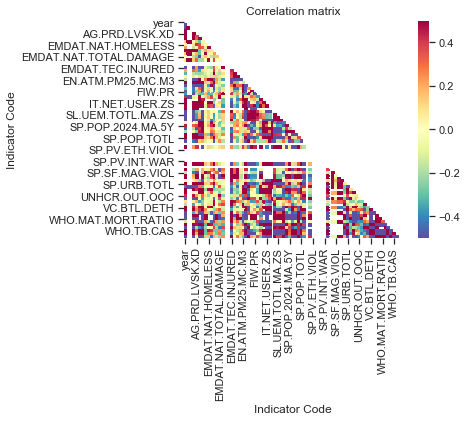

In [18]:
corrs = data.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.5, vmax=.5)
plt.title('Correlation matrix')

In [19]:
top_EDP = EDP_df['Indicator Name'].values[:10]
top_IDP = IDP_df['Indicator Name'].values[:10]

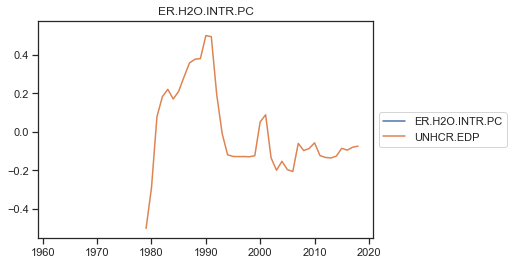

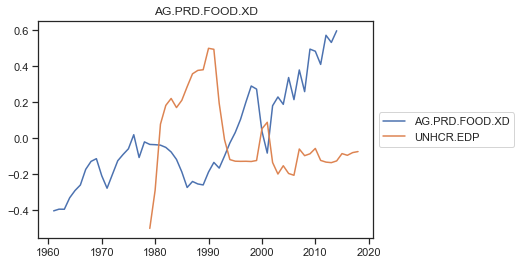

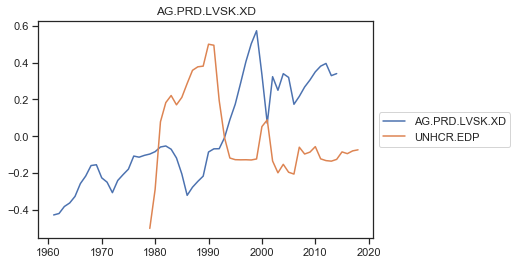

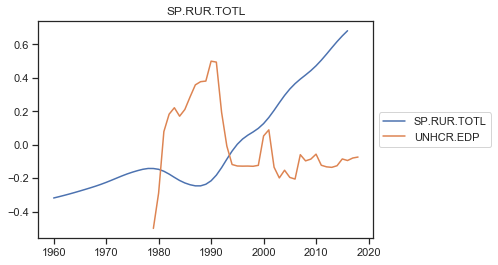

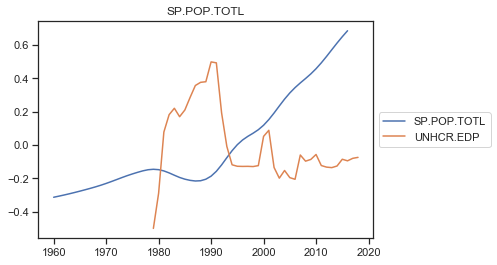

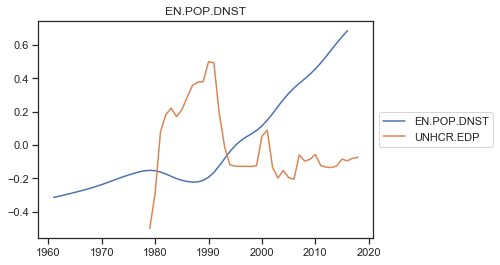

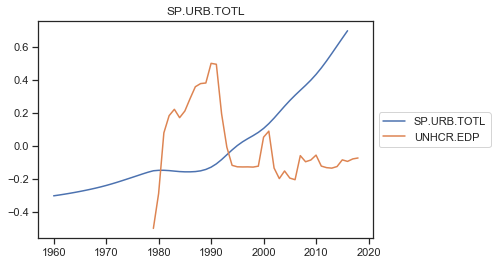

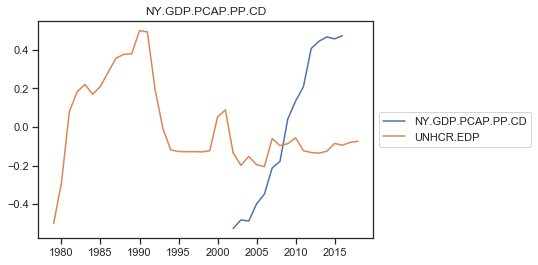

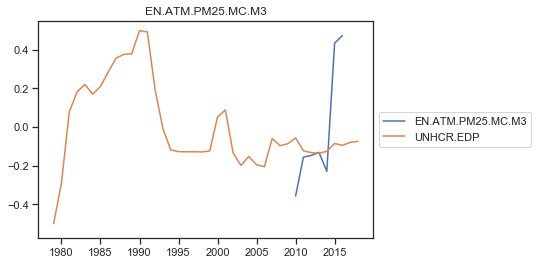

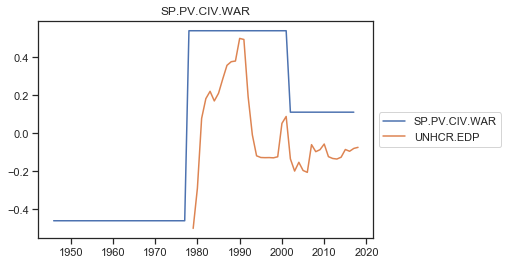

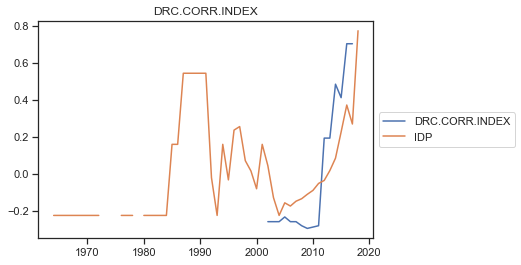

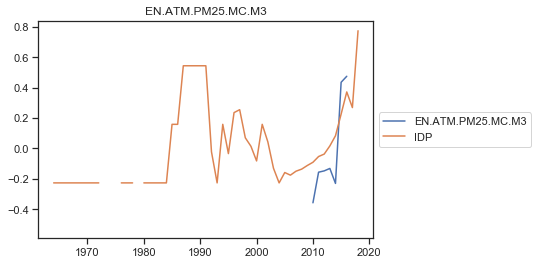

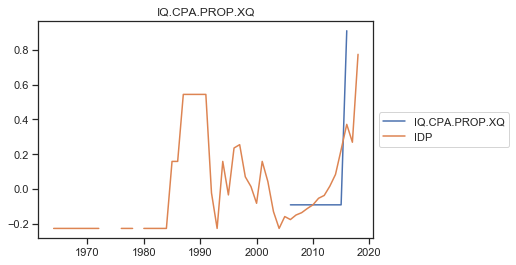

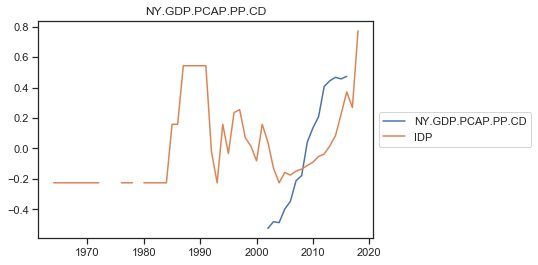

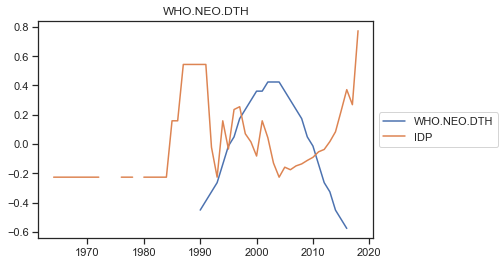

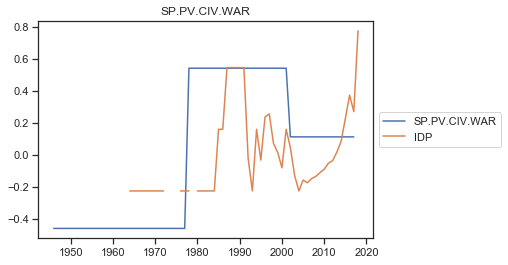

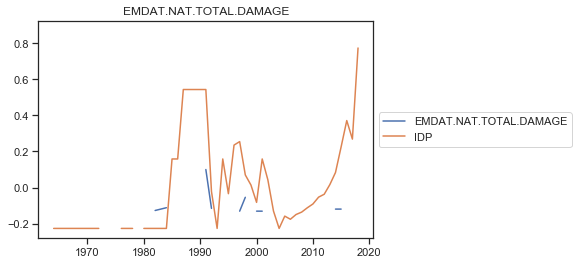

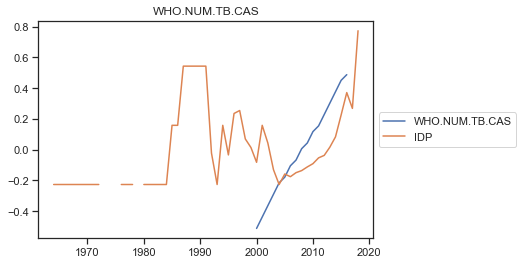

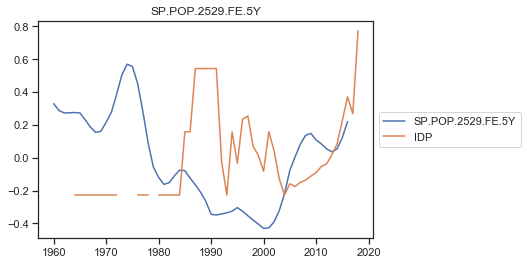

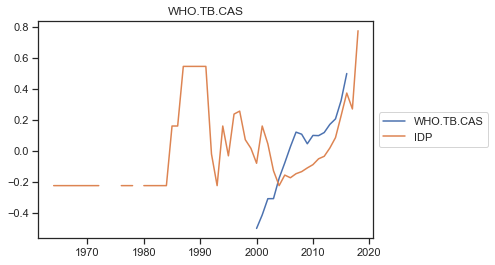

In [20]:
data['IDP'] = data['IDP'].apply(lambda x: (x - np.mean(data['IDP'])) / (np.max(data['IDP']) - np.min(data['IDP'])))
data['UNHCR.EDP'] = data['UNHCR.EDP'].apply(lambda x: (x - np.mean(data['UNHCR.EDP'])) / (np.max(data['UNHCR.EDP']) - np.min(data['UNHCR.EDP'])))

for i in top_EDP:
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    plt.plot(data.year,data[i].values)
    plt.plot(data.year,data['UNHCR.EDP'].values)  
    plt.title(i)
    plt.legend([i, 'UNHCR.EDP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

for i in top_IDP:
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    plt.plot(data.year,data[i].values)
    plt.plot(data.year,data['IDP'].values)  
    plt.title(i)
    plt.legend([i, 'IDP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

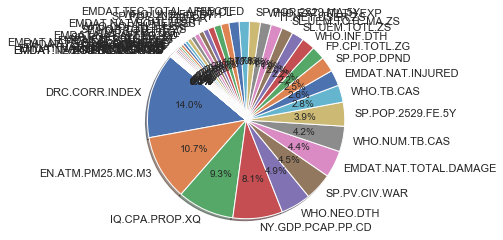

In [21]:
labels = IDP_df["Indicator Name"].values
values = IDP_df["r2"].values

# Plot
plt.pie(values, labels=labels, 
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

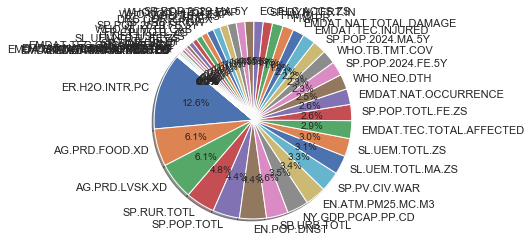

In [22]:
labels = EDP_df["Indicator Name"].values
values = EDP_df["r2"].values

# Plot
plt.pie(values, labels=labels, 
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()